In [1]:
import numpy as np
import pandas as pnd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from functions.KNN import *
from collections import Counter
from functions.PCA import *
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sb

dataset = 1
match dataset:
    case 1:
        test = 'fashion-mnist_test.csv'
        train = 'fashion-mnist_train.csv'
    case 2: 
        test = "mnist_test.csv"
        train = "mnist_train.csv"
testdata = pnd.read_csv(test)
traindata = pnd.read_csv(train)
testdata_pixel = testdata.drop(testdata.columns[0], axis=1).to_numpy()
traindata_pixel = traindata.drop(traindata.columns[0], axis=1).to_numpy()
label_train = traindata[traindata.columns[0]].to_numpy()
label_test = testdata[testdata.columns[0]].to_numpy()


cnn_test = testdata_pixel.reshape(-1,28,28) /255.0
cnn_train = traindata_pixel.reshape(-1,28,28) /255.0
cnn_test = np.expand_dims(cnn_test,axis=3)
cnn_train = np.expand_dims(cnn_train,axis=3)
cnn_label_test = tf.keras.utils.to_categorical(label_test)
cnn_label_train = tf.keras.utils.to_categorical(label_train)

img = traindata_pixel.reshape((-1,28,28)) #only relevant for visualisation
num_img = traindata_pixel.shape[0]
PCs_train, PCs_test = pca(traindata_pixel,testdata_pixel,0.9)

(784, 784)
Our eigenvectors explain 90.06328752165619 percent of total variance
137 eigenvectors are used


In [7]:

bastis_model = Sequential([
  Conv2D(16, 5, input_shape=(28, 28, 1), activation="relu",padding="same"),
  Conv2D(16, 5, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  BatchNormalization(),
  Conv2D(32, 3, activation="relu",padding="same"),
  Conv2D(32, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  BatchNormalization(),
  Conv2D(64, 3, activation="relu",padding="same"),
  Conv2D(64, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  BatchNormalization(),
  Conv2D(64, 3, activation="relu",padding="same"),
  Conv2D(64, 3, activation="relu",padding="same"),
  Conv2D(64, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=1),
  BatchNormalization(),
  Flatten(),
  Dense(256,activation="relu"),
  Dropout(0.1),
  Dense(512,activation="relu"),
  Dropout(0.1),
  Dense(10, activation='softmax'),
])
bastis_model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    min_delta=0.01,
    patience=2,
    verbose=1,
    mode='auto',
    baseline=0.9,
    restore_best_weights=False,
    start_from_epoch=0
)
bastis_model.fit(
  cnn_train,
  cnn_label_train,
  validation_data=(cnn_test, cnn_label_test),
  epochs=20,
  batch_size=64
)


Epoch 1/20
128/938 [===>..........................] - ETA: 1:13 - loss: 0.7434 - accuracy: 0.7297

KeyboardInterrupt: 

Kalkuliert Dist und Zwischenspeichern der Ergebnisse

In [6]:
def knn_quality(PCs_train, PCs_test, k, label_train, label_test, testsize, random = False):
    """returns the accuray of the KNN for test images

    Args:
        PCs_train (numpy array): transformed training data
        PCs_test (numpy array): transformed testing data
        k (int): number of neighbours 
        label_train (numpy array 1D): labels of training data
        label_test (numpy array 1D): labels of testing data
        testsize (int): number of testing images you want to classify
        random (boolean): when True, looks at random test images, when False, looks at first testsize images

    Returns:
        float: accuracy
    """
    if random == True:
        indices_test = np.random.choice(PCs_test.shape[0],testsize)
    else:
        indices_test = [*range(testsize)]
    distances = np.linalg.norm(PCs_test[indices_test, None] - PCs_train, axis=2)
    neighbour_index = np.argpartition(distances, kth=k-1, axis=1)[:,:k]
    neighbour_label = label_train[neighbour_index]
    result = []
    for subarray in neighbour_label:
        data = Counter(subarray)
        most_common_item = data.most_common(1)[0][0]
        result.append(most_common_item)
    result = np.array(result)
    return result



print(knn_quality(PCs_train, PCs_test, 10, label_train, label_test, 200))




[0 1 2 2 3 6 8 4 5 0 3 2 4 6 8 5 6 3 6 4 4 4 2 1 5 7 8 4 4 1 9 7 7 8 1 0 9
 8 6 8 2 0 4 6 2 0 3 3 2 3 2 4 9 3 0 9 9 4 0 3 4 5 6 6 1 1 0 9 5 2 7 3 4 6
 5 7 1 6 1 3 9 8 1 2 4 8 9 4 1 6 3 3 6 2 5 0 4 7 7 3 9 3 9 8 8 2 3 8 2 7 5
 5 4 2 7 5 0 2 7 3 0 5 4 4 7 0 5 5 0 3 1 5 9 4 9 6 4 4 6 4 3 3 3 2 2 6 0 0
 1 3 4 3 3 1 9 3 3 0 9 5 6 7 7 3 2 4 0 6 7 2 4 8 9 0 6 4 4 5 7 9 9 1 3 9 1
 7 5 6 0 7 4 7 1 6 6 0 2 4 0 9]


In [5]:
def knn_quality2(PCs_train, PCs_test, k, label_train, label_test, testsize):
    """returns the accuray of the KNN for test images

    Args:
        PCs_train (numpy array): transformed training data
        PCs_test (numpy array): transformed testing data
        k (int): number of neighbours 
        label_train (numpy array 1D): labels of training data
        label_test (numpy array 1D): labels of testing data
        testsize (int): number of testing images you want to classify
        
    Returns:
        knn for number of testsize images
    """

    result = np.array([])
    for i in range(0, len(label_test), testsize):
        distances = np.linalg.norm(PCs_test[i:i+testsize, None] - PCs_train, axis=2)
        neighbour_index = np.argpartition(distances, kth=k-1, axis=1)[:,:k]
        neighbour_label = label_train[neighbour_index]
        batch_result = []
        for subarray in neighbour_label:
            data = Counter(subarray)
            most_common_item = data.most_common(1)[0][0]
            batch_result.append(most_common_item)
        batch_result = np.array(batch_result)
        batch_result = batch_result.astype(int)
        result = result.astype(int)
        result = np.concatenate((result, batch_result), axis=0)
        print(accuracy)
    return result

asdf = knn_quality2(PCs_train, PCs_test, 3, label_train, label_test, 40)

NameError: name 'indices_test' is not defined

(10000,)
(10000,)
[0 1 2 ... 8 8 1]
0.8624
               T-shirt / Top  Trouser  Pullover  Dress   Coat  Sandal  Shirt   
T-shirt / Top          79.17     0.20      1.58   2.94   0.19    0.11  16.77  \
Trouser                 0.00    99.18      0.21   0.51   0.00    0.00   0.10   
Pullover                1.70     0.10     79.56   1.11   7.38    0.00   8.23   
Dress                   1.61     1.73      1.16  90.07   2.30    0.00   2.51   
Coat                    0.38     0.10     12.86   3.75  76.25    0.00   7.93   
Sandal                  0.00     0.00      0.00   0.00   0.00   97.90   0.00   
Shirt                  10.98     0.51      9.80   2.84   9.48    0.00  64.26   
Sneaker                 0.09     0.00      0.00   0.00   0.00    7.40   0.00   
Bag                     0.66     0.00      0.21   0.10   0.19    0.11   0.60   
Ankle Boot              0.09     0.10      0.00   0.00   0.00    4.97   0.00   

               Sneaker    Bag  Ankle Boot  
T-shirt / Top     0.00   0.31   

<AxesSubplot:>

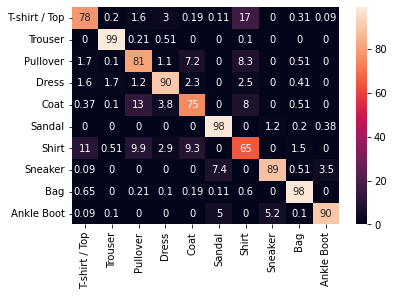

In [46]:
print(asdf.shape)
print(label_test.shape)
print(asdf)
class_names = np.array(["T-shirt / Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])

indices_test = [*range(10000)]
accuracy = np.sum(asdf==label_test[indices_test])/10000
print(accuracy)

#Note: Row: true label
#Column: Predicted label
    
y_pred = asdf
y_true = label_test
class_names = np.array(["T-shirt / Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
conf = sklearn.metrics.confusion_matrix(y_pred, label_test)
conf_df = pnd.DataFrame(conf, index=class_names, columns=class_names)
conf_df = round(conf_df*100 / conf_df.sum(axis=1),2)
print(conf_df)
conf_df = round(conf_df*100 / conf_df.sum(axis=1),2)
print(conf_df)
sb.heatmap(conf_df, annot=True)

In [ ]:

# Plot for 2D Principal components
#def principal_comp2D
PCs_train_reduced = pca(traindata_pixel, testdata_pixel, 2)
print(pcs_train_reduced_df = pd.DataFrame(PCs_train_reduced))
